*Author: David Rodrigues* | https://www.linkedin.com/in/davidrodrigues/ | davidrodriguessp@hotmail.com | https://github.com/davidrodriguessp

# Building a Workflow to Compete in Kaggle: Predicting which Passengers Survived the Titanic Shipwreck

![titanic](https://images.unsplash.com/photo-1500077423678-25eead48513a?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2070&q=80)

<center>Photo by Руслан Гамзалиев on Unsplash</center>

The objective of this project is to provide a guide on how to build a project to take part in Kaggle competitions. [Kaggle](https://www.kaggle.com/)  is a website in which companies propose a challenge in which machine leaning practitioners compete and try to provide the best algorithm to predict a phenomenon. The one that manages to reach the best accuracy wins the competition and receives an award.

For this project we used the famous [Titanic](https://www.kaggle.com/c/titanic) competition, in which a dataset with passanger characteristics is provided and participants need to build a model to try to predict passangers survival. Two datasets are available in the website: the training set (`train.csv`) and test set (`test.csv`). [Here](https://www.kaggle.com/c/titanic/data) you will find the datasets and a data dictionary describing each of the columns.

The workflow follows the 7 steps below:
1. **Objective**: define the *question to be answered* and the objective of the project.
2. **Data cleaning**: remove irrelevant columns, deal with missing values, deal with non-numerical data, check for class imbalance.
3. **Data exploration and Feature Engeneering**: find patterns and relations between columns and do feature engeneering, that is, create new features out of the ones available in the raw data.
4. **Feature selection**: select the best subset of features, check for collinearity and relationship with the target column.
5. **Model selection/tuning**: training a number of models with different hyperparameters to find the best performer.
6. **Final Model**: train the final model with all training data available and make predictions.
7. **Submission**: create a file to submite to Kaggle.

# 1. Objective and Question to Be Answered
In the case of the Titanic competition, the objective is to build a model to predict whether a passanger survived or not.

We can define the question to be answered as:

<font size=3>*How can we predict survival for a passanger on the Titanic based on her personal characteristics?*<font size>

# 2. Data Cleaning
We were provided with two datasets from Kaggle, `train.csv` and `test.csv`. All model development will be conducted on the `train` dataset, since it is the one that includes the information on passangers' survival. The other dataset, `test`, includes only the other columns. 

It is important to notice that all data processing and transformation we perform in the training set will also need to be done in the test dataset. That's why during the project we will create functions that allow us to perform the operations on a new data set.

We start by reading the files into Pandas and renaming the `test` dataset into `holdout`.

In [1]:
import pandas as pd
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')
holdout.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


## Remove Columns and Deal with Missing Values
The `PassengerId` and `Ticket` seem not to be relevant to our objective. We will create a function `remove_columns( )` to remove these two.

In [2]:
# Create a function to remove the columns we will not use for modeling
def remove_columns(df):
    '''This function takes a dataframe and removes the columns PassengerId, Ticket and Name,
    returning a new dataframe without these two columns.''' 
    df = df.drop(['PassengerId', 'Ticket'], axis=1)
    return df

Let's check for missing values in our dataset. We need to check both the `train` and `holdout` (`test`) datasets for missing values.

In [3]:
# Check for missing values in the train and holdout dataset. Display the percentage of missing values per column
print('Percentage of Missing in Train: ', '\n', train.isnull().sum() / train.shape[0])
print('\n')
print('Percentage of Missing in Holdout: ', '\n', holdout.isnull().sum() / holdout.shape[0])

Percentage of Missing in Train:  
 PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64


Percentage of Missing in Holdout:  
 PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.205742
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.002392
Cabin          0.782297
Embarked       0.000000
dtype: float64


`Cabin` has nearly 80% of values missing. We will update the `remove_columns()` function and remove it as well. `Age` has 20% of values missing, but seems to be an important column to predict survival. We will keep it and deal with its missing values. 

`Embarked` has only 0.2% of values missing. As it is a categorical column, we will fill it with the most frequent value. `Fare` has missing values only in the `holdout` dataset, but we will need to deal with them. As they are only 0.2%, we will fill them with the mean.

In [4]:
# Update the remove_columns() function to remove the Cabin column.
def remove_columns(df):
    '''This function takes a dataframe and removes the columns PassengerId, Ticket and Name, and Cabin
    returning a new dataframe without these two columns.''' 
    df = df.drop(['PassengerId', 'Ticket', 'Cabin'], axis=1)
    return df

In [5]:
# Exploring the Embarked column
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

The most common value in the `Embarked` column is `S`, which stands for the port of Southampton. Let's fill the missing values in this column with this most frequent value.

In [6]:
# Create a function to fill the Embarked missing values with S
def process_Embarked(df):
    '''This function accepts as input a dataframe and fills the missing values for the Embarked
    column with the value of S, which stands for the Southamptom port.'''
    df['Embarked'] = df['Embarked'].fillna('S')
    return df

Now, let's deal with the missing values in the `Fare` column. As it is a numeric column with a very small number of missing, we will fill them with the mean.

In [7]:
# Create a function to fill the Fare column missing values with the mean
def process_Fare(df):
    '''This funciton accepts as input a dataframe and fills the missing values for the Fare
    column with the mean.'''
    df['Fare'] = df['Fare'].fillna(df['Fare'].mean())
    return df

The tricky one is `Age`. It is a numeric column, but it is risky to fill all values with the mean since they are too many, close to 20%.

We will fill these missing values with negative 1. This will allow us to identify and them later, and most probably convet it into a categorical variable.

In [8]:
# Fill missing values in the Age colum with -1.
def process_Age(df):
    '''This funciton will take a dataframe as input, fill all values for the Age column that are missing
    with -1, and return a new dataframe.'''
    df['Age'] = df['Age'].fillna(-1)
    return df

## Dealing with Non-Numeric Data and Checking for Class Imbalance
Let's check first for the potential issue of Class Imbalance. When we analyze the target column in a binary classification problem, sometimes one class is much more frequent than the other. For example, in our case there could be the case that most passangers survived or did not survive. When this happend, the accuracy measured in Machine Learning models tend to be biased towards the most frequent class. 

In [9]:
# Calculate the values frequency for the Survived column
print('Frequency for the Train Dataset: ', '\n', train['Survived'].value_counts(normalize=True))

Frequency for the Train Dataset:  
 0    0.616162
1    0.383838
Name: Survived, dtype: float64


The distribution between Survived and Not-Survived is about 40/60. This shows that our data is considerably balanced. We can go on with the analysis without worrying about class imbalance.

Let's now deal with the non-numeric columns: `Pclass`, `Sex`, `Embarked` and `Name`. In Machine Learning we can only use numeric values for modeling, so let's process these columns and convert them into dummy variables.

Besides, we know that if a categorical variable has `n` values, we need only `n-1` dummy columns to represent it, so while converting them, we will drop the first category. The category we drop we will consier as the *reference* column to interpret the others. Let's create a function to convert these columns into dummies.

Before we convert them into dummy variables, let's clean the `Name` column.

### Processing the Name Column
The name column has text values. We need to extract information we are able to analyze from it. Let´s see the first rows.

In [10]:
# Display the first rows of the Name column
train.Name.head(5)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

Each name is unique, so it will not help in our analysis. However, we see that each name includes a title. There is a pattern for each title: a comma, a space, the title and a period. Let's extract the titles taking into account this pattern and save them in a new variable.

In [11]:
# Create a new variable titles for both the train and holdout datasets
titles_train = train['Name'].str.extract(" ([a-zA-Z]+)\.")
titles_holdout = holdout['Name'].str.extract(" ([a-zA-Z]+)\.")

Now, let´s see the unique titles that we have inside the train and also in the holdout datasets. Remember that all operations will have to be done in both datasets.

In [12]:
# Print the unique titles in both the train and holdout datasets
print('Unique Titles in the Train Dataset: ', '\n', titles_train[0].unique())
print('\n')
print('Unique Titles in the Holdout Dataset: ', '\n', titles_holdout[0].unique())

Unique Titles in the Train Dataset:  
 ['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer']


Unique Titles in the Holdout Dataset:  
 ['Mr' 'Mrs' 'Miss' 'Master' 'Ms' 'Col' 'Rev' 'Dr' 'Dona']


The only title included in the holdout dataset that is not in the train dataset is `Dona`. Let's create a list with the complete list of titles.

In [13]:
# Complete list of titles
titles = list(titles_train[0].unique()) + list(['Dona'])
print(titles)

['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms', 'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess', 'Jonkheer', 'Dona']


There are 18 different titles. To make modeling simpler, let' reclassify them into three categories: `common`, `officer` and `royalty`. Let's create a function to extract the titles in a new column `titles` and convert them into the three categories.

In [14]:
# Create a function to process the name function
def process_Name (df):
    '''This function accepts a dataframe as input, extracts the title from the Name column into a new column called
    Title, and convert the titles according to the dictionary into three categories: common, officer and royalty.
    Finally, the function removes the original column Name.'''
    # Dictionary to convert the titles into 3 categories
    title_dict = {
        "Mr" :         "common",
        "Mme":         "common",
        "Ms":          "common",
        "Mrs" :        "common",
        "Master" :     "common",
        "Mlle":        "common",
        "Miss" :       "common",
        "Capt":        "officer",
        "Col":         "officer",
        "Major":       "officer",
        "Dr":          "officer",
        "Rev":         "officer",
        "Jonkheer":    "royalty",
        "Don":         "royalty",
        "Sir" :        "royalty",
        "Countess":    "royalty",
        "Dona":        "royalty",
        "Lady" :       "royalty"
    }
    df['Title'] = df['Name'].str.extract(', ([A-Za-z]+)\.')
    df['Title'] = df['Title'].map(title_dict)
    df = df.drop('Name', axis=1)
    return df

### Creating Dummy Columns for each Categorical Variable
Most Machine Learning algorithms can only be applied to numeric values. We will need to convert each of our categorical columns into dummies.

In [15]:
# Create a function to convert the three categorical columns Pclass, Sex and Embarked into Dummies
def convert_dummies(df):
    '''This function will take a dataframe as input, and convert the columns Pclass, Sex, Embarked and Title
    into dummy variables. It will also drop the first category which will act as the reference, and
    drop the original categorical columns that contained all categories.'''
    categories = ['Pclass', 'Sex', 'Embarked', 'Title']
    for category in categories:
        dummies = pd.get_dummies(df[category], drop_first=True, prefix=category)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(category, axis=1)
    return df

For `Pclass`, we ended up with two columns: `class_2` and one for `class_3`, this makes `class_1` our reference column. As for `Sex`, we kept only the `Male` column, and for `Embarked`, the ports `Q` and `S`. For `Title`, we will have two columns: `officer` and `royalty`.

Now that we finished the Cleaning phase, let's create a function that combines all steps for data cleaning and returns a new cleaned dataset.

## Create a Function to Combine All Preprocessing Steps

In [16]:
# Create a function that includes all steps performed for data cleaning
def preprocess(df):
    '''This function takes a dataframe as input and applies the functions to remove some of the original columns,
    deals with missing values and non-numeric columns. '''
    df = remove_columns(df)
    df = process_Embarked(df)
    df = process_Fare(df)
    df = process_Age(df)
    df = process_Name(df)
    df = convert_dummies(df)
    return df

Now, we can use the function `preprocess()` on the `train` dataset to verify how our clean data looks.

In [17]:
# Print data after applying the preprocess() function to check how the function is working
preprocess(train).head(2)

,Survived,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Title_officer,Title_royalty
0,0,22.0,1,0,7.2500,0,1,1,0,1,0,0
1,1,38.0,1,0,71.2833,0,0,0,0,0,0,0


# 3. Data Exploration and Feature Engeneering
On this step, we will explore the data and create new features based on the ones present in the raw data.

We will look for patterns in the data and relationship between columns. Let's start exploring the `Age` column. As this column is numeric, we will split it into bins, and check the mean of the `Survival` column for each bin. This way, we will be able to see if the probability to survive was higher (or lower) for specific age groups.

## The Age Column

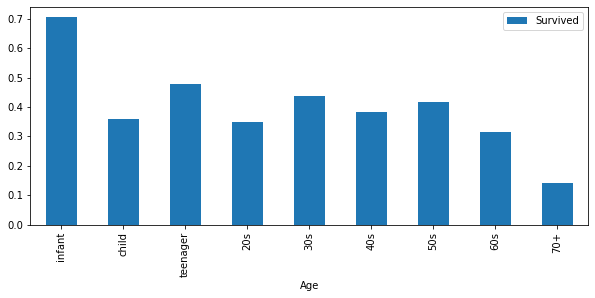

In [18]:
# Create a new Series called Age_categorical, with 9 bins.
import numpy as np
import matplotlib.pyplot as plt
cut_points = [-1, 5, 12, 17, 29, 39, 49, 59, 69, 80]
cut_labels = ['infant', 'child', 'teenager', '20s', '30s', '40s', '50s', '60s', '70+']
age_categorical = pd.cut(x=train['Age'], bins=cut_points, labels=cut_labels)
pivot_age = pd.pivot_table(data=train, index=age_categorical, values='Survived', aggfunc=np.mean)

# Plot the age_categorical column with the mean survival rate per bin
pivot_age.plot(kind='bar', figsize=(10,4))
plt.show()

Looking at the probability to survive per age category, we see that the relationship seems to be non-linear. Besides, it does not look like it would fit into an s-shaped form. Therefore, let's reduce the number of bins according to the distribution and turn `Age` into a categorical column.

We should not forget that in the data cleaning phase, we converted all missing values to `-1`. Let's convert `-1` into missing values. Based on the distribution above, let's create a column `Age_categorical` with the following categories:
- Missing: considering the `-1` values
- Infant: 0-5
- Child: 6-12
- Teenager: 13-17
- Young Adult: 18-39
- Adult: 40-59
- Senior: 60-80

Below we define a new function to create this column, convert the categories into dummies and remove the original `Age` column.

In [19]:
# Create a function to create the new column Age_categorical
def Age_categorical(df):
    '''Create a new function that accepts a dataframe as input, converts the Age column into a categorical
    variable, convert the categories in dummy variables and removes the original Age column.'''
    cut_points = [-5, -1, 5, 12, 17, 39, 59, 80]
    cut_labels = ['missing', 'infant', 'child', 'teenager', 'young adult', 'adult', 'senior']
    df['Age_categorical'] = pd.cut(x=df['Age'], bins=cut_points, labels=cut_labels)
    dummies = pd.get_dummies(data=df['Age_categorical'], prefix='Age', drop_first=True)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop('Age_categorical', axis=1)
    df = df.drop('Age', axis=1)
    return df

## The SibSp and Parch Columns
`SibSp` stands for the number of siblings and spouses onboard. The `Parch` column includes the number of parents and children. Let's explore these two columns.

Let's start by checking on variable types and distribution.

In [20]:
# Check dtypes
train[['SibSp', 'Parch']].dtypes

SibSp    int64
Parch    int64
dtype: object

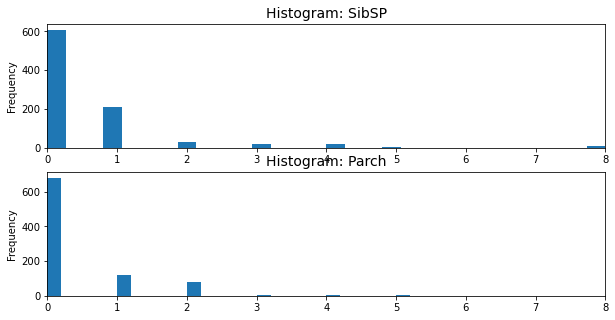

In [21]:
# Displaying the distribution of data on these columns
plt.figure(figsize=(10,5))
plt.subplot(211)
train['SibSp'].plot(kind='hist', bins=30)
plt.xlim(0,8)
plt.title('Histogram: SibSP', fontsize=14)
plt.subplot(212)
train['Parch'].plot(kind='hist', bins=30)
plt.xlim(0,8)
plt.title('Histogram: Parch', fontsize=14)
plt.show()

The two variables have a very similar distribution, concentrated on the lowest values, especially 0s and 1s. Let's now calculate how these columns are related to survival.

In [22]:
# Divide the columns in 5 bins and check the survival rate per bin
bins = [-1, 0, 1, 2, 4, 8]
labels = ['0', '1', '2', '3-4', '5+']
sibsp_bins = pd.cut(train['SibSp'], bins=bins, labels=labels)
parch_bins = pd.cut(train['Parch'], bins=bins, labels=labels)

pivot_sibsp = pd.pivot_table(data=train, index=sibsp_bins, values='Survived')
pivot_parch = pd.pivot_table(data=train, index=parch_bins, values='Survived')

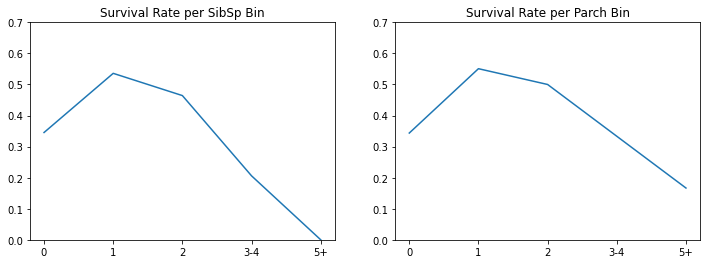

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.plot(pivot_sibsp)
ax1.set_ylim(0,0.7)
ax1.set_title('Survival Rate per SibSp Bin')

ax2.plot(pivot_parch)
ax2.set_ylim(0,0.7)
ax2.set_title('Survival Rate per Parch Bin')

plt.show()

As we can see above, both columns have a very similar distribution. They start with a probability to survive slightly higher than 30% when passangers are alone, doubles when they travel with 1 person, and start going down, when the number of people increases.

Let's check how much this two variables are correlated. We will keep the two is the correlation is lower than 70%.

In [24]:
# Check the correlation between SibSp and Parch
train[['SibSp', 'Parch']].corr()

,SibSp,Parch
SibSp,1.000000,0.414838
Parch,0.414838,1.000000


Considering the correlation, let's keep both columns. Considering the similarities of the distributions of the two columns, let's create a new variable `Relatives` which will be the sum of the other two variables.

### Create a New Variable Relatives

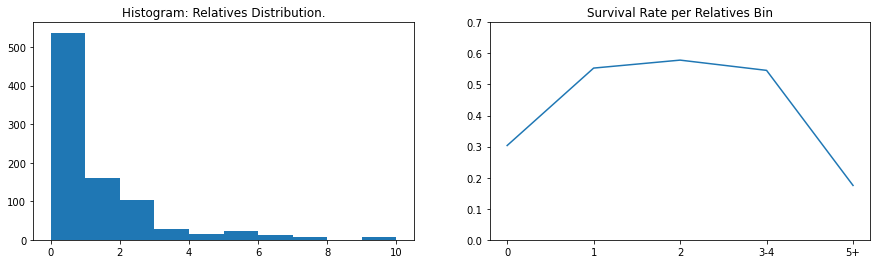

In [25]:
# Combining the two columns in one variable
relatives = train['SibSp'] + train['Parch']

# Display the probaility to Survive per relative group
relatives_bins = pd.cut(relatives, bins=bins, labels=labels)
pivot_relatives = pd.pivot_table(data=train, index=relatives_bins, values='Survived')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
ax1.hist(relatives)
ax1.set_title('Histogram: Relatives Distribution.')

ax2.plot(pivot_relatives)
ax2.set_ylim(0,0.7)
ax2.set_title('Survival Rate per Relatives Bin')

plt.show()

Similar to the results when we had the two variables separated, `Relatives` is right-skewed, highly concentrated with passangers traveling alone or with only one relative onboard. 

The relationship between the number of relatives and the probability to survive is not linear, and not s-shaped. Therefore, we may consider also binning this variable. Considering the relationship with survival rate, we will consider three bins:
- 0 Relatives
- 1-4 relatives
- 5+ relatives

In [26]:
# Define a function to create the Relatives column and convert it into dummy variables
def create_Relatives(df):
    '''This function will take a dataframe as input, create the new column relative, convert this new column into
    a categorical variable with 3 bins, convert the categorical variable into dummies and drop the original numeric
    relative column.'''
    df['Relatives'] = df['SibSp'] + df['Parch']
    df['Relatives'] = pd.cut(df['Relatives'], bins=[-1, 0, 4, 10], labels=['Alone', '1-4', '5+'])
    dummies = pd.get_dummies(df['Relatives'], drop_first=True, prefix='Relatives')
    df = pd.concat([df, dummies], axis=1)
    df = df.drop('Relatives', axis=1)
    return df

Now, we will also define another function to transform SibSp and Parch into categorical variables.

### Convert SibSp and Parch into Categorical Variables

In [27]:
# Create a function to process SibSp and Parch
def process_SibSp_Parch(df):
    '''This function will take a dataframe as input and for each of the two columns SibSp and Parch: convert them
    into a categorical variable with three bins, convert them into dummies and drop both the original numeric 
    column and the categorical variable, keeping only the dummies.'''
    columns = ['SibSp', 'Parch']
    for col in columns:
        df[col+'_categorical'] = pd.cut(df[col], bins=[-1, 0, 2, 8], labels=['0', '1-2', '3+'])
        dummies = pd.get_dummies(df[col+'_categorical'], drop_first=True, prefix=col)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop([col, col+'_categorical'], axis=1)
    return df

Next, let's verify the `Fare` column.

## The Fare Column
This column is also numeric. Let's explore its distribution and relation with `Survived` to verify the best way to use it for modeling.

In [28]:
# Check on the data type
train.Fare.dtype

dtype('float64')

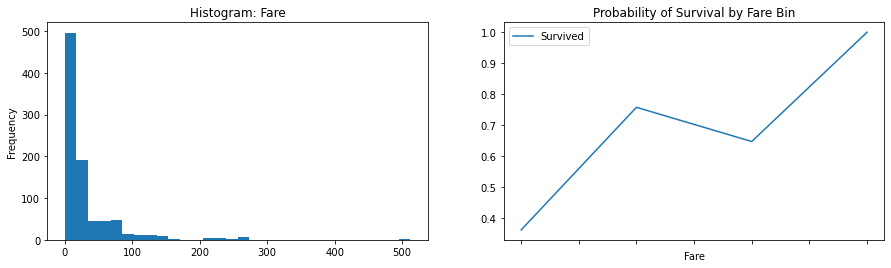

In [29]:
# Verify data distribution and how it is related to survival
# Divide Fare in 10 bins
fare_bins = pd.cut(train['Fare'], bins=5)

# Create a pivot with the survival rate per bin
pivot_fare = pd.pivot_table(train, index=fare_bins, values='Survived', aggfunc='mean')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
train['Fare'].plot(kind='hist', bins=30, ax=ax1)
ax1.set_title('Histogram: Fare')

pivot_fare.plot(ax=ax2)
ax2.set_title('Probability of Survival by Fare Bin')
plt.show()

In the plots above we see that `Fare` is right-skewed, concentrated in its lower values.The distribution of the probability to survive by Fare bin ideally would have a s-shaped/sigmoid-like distribution. Although it is not s-shaped, we consider reasonable that the probability to survive grows quickly as the fare grows, stops growing, then grows again up to 1.

Let's consider that the `Fare ` column might be adequate for modeling as a numeric variable. As all other columns are dummies, with 0s and 1s, let's rescale `Fare` keeping the distribution but making it range from 0 to 1.

In [30]:
# Fit a scaler with the training data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train[['Fare']])

MinMaxScaler()

In [31]:
# Create a function that uses the the scaler and normalizes the Fare column
def scale_Fare(df):
    '''This function takes a dataframe and rescales the Fare column using MinMax with a range from 0 to 1.
    It returns a new dataframe with the column Fare_scaled, removing the original Fare column.'''
    df['Fare_scaled'] = scaler.transform(df[['Fare']])
    df = df.drop('Fare', axis=1)
    return df

Now, let's update our `preprocess()` function including the transformations we conducted during exploration and feature engineering. 

In [32]:
# Update the preprocess() function including transformations we conducted during data exploration and feature engeneering.
def preprocess(df):
    '''This function takes a dataframe as input and applies the functions to remove some of the original columns,
    deals with missing values and non-numeric columns. '''
    df = remove_columns(df)
    df = process_Embarked(df)
    df = process_Fare(df)
    df = process_Age(df)
    df = process_Name(df)
    df = convert_dummies(df)
    df = Age_categorical(df)
    df = create_Relatives(df)
    df = process_SibSp_Parch(df)
    df = scale_Fare(df)
    return df

See below the first rows of the training dataset after applying the `preprocess()` function.

In [33]:
# Display first rows of train dataset after applying the preprocess() function
preprocess(train).head(2)

,Survived,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Title_officer,Title_royalty,Age_infant,Age_child,...,Age_young adult,Age_adult,Age_senior,Relatives_1-4,Relatives_5+,SibSp_1-2,SibSp_3+,Parch_1-2,Parch_3+,Fare_scaled
0,0,0,1,1,0,1,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0.014151
1,1,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0.139136


# 4. Feature selection
During this step we will first check for collinearity among predictors and remove the ones that are highly correlated with each other. Then, we will use scikit-learn's feature_selection.RFECV class to automate selecting the best-performing features using recursive feature elimination.

Let's start by checking for collinearity among the features.

## Identifying Features which May be Highly Correlated

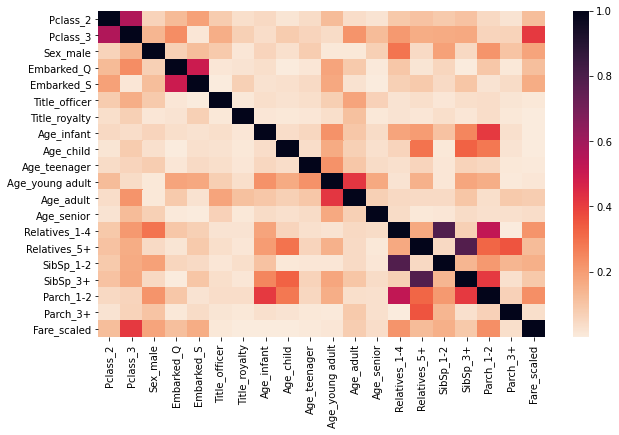

In [34]:
# Display a heatmap with correlation among the features
feature_correlations = preprocess(train).iloc[:, 1:].corr().abs()

import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(feature_correlations, cmap="rocket_r")
plt.show()

The highest correlations among features are between:
- Relatives_1-4 and SibSp_1-2 (**79%**)
- Relatives_5+ and SibSp_3+ (**78%**)
- Pclass_2 and Pclass_3 (**57%**)
- Relatives_1-4 and Parch_1-2 (**53%**)

Based on this results let's remove 4 columns to reduce multicollinearity:
- SibSp_1-2
- SibSp_3+
- Pclass_2
- Parch_1-2

In [35]:
# Create a function that removes these 4 columns from the data
def remove_correlated(df):
    '''This function takes a dataframe as input and removes 4 columns: SibSp_1-2, SibSp_3+, Pclass_2 and Parch_1-2.
    It returns a new dataframe without excluding these four columns.'''
    df = df.drop(['SibSp_1-2', 'SibSp_3+', 'Pclass_2', 'Parch_1-2'], axis=1)
    return df

Let's update the preprocess function removing these 4 columns.

In [36]:
# Update the preprocess() function to remove the 4 columns to avoid collinearity among features
def preprocess(df):
    '''This function takes a dataframe as input and applies the functions to remove some of the original columns,
    deals with missing values and non-numeric columns. '''
    df = remove_columns(df)
    df = process_Embarked(df)
    df = process_Fare(df)
    df = process_Age(df)
    df = process_Name(df)
    df = convert_dummies(df)
    df = Age_categorical(df)
    df = create_Relatives(df)
    df = process_SibSp_Parch(df)
    df = scale_Fare(df)
    df = remove_correlated(df)
    return df

## Recursive Feature Elimination with Cross Validation
With recursive feature elimination we can test multiple models with different combinations of features. For each combination, we measure the predictive accuracy of the model. At the end, we identify the combination of features that provided the best performance using cross validation.

To be able to do this, we will use a class from scikitt-learn called `RFECV` (aka Recursive Feature Elimination with Cross Validation).

Let's write a function that:
- Accepts a dataframe as input
- Applies all data preprocessing transformations to prepare data for Machine Learninng
- Uses recursive feature elimination and the Logistic Regression algorithm to find the best-performing set of features

In [37]:
# Import the functions
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

In [38]:
# Create a new function select_features
def select_features (df):
    '''Accepts a dataframe as input, applies the preprocess() function to prepare data for Machine Learning, create all_X 
    with all features but Survived, and all_y with Survived, use RFECV with Logistic Regression to perform recursive
    feature elimination with random_state 45 and 10-fold cross validation. Return a list with the best columns.'''
    df = preprocess(df)
    all_X = df.drop('Survived', axis=1)
    all_y = df['Survived']
    lr = LogisticRegression(random_state=45, max_iter=1000)
    selector = RFECV(lr, cv=10)
    selector.fit(all_X, all_y)
    return list(all_X.columns[selector.support_])

In [39]:
# Now let's use the select_features function on the train dataset and save the best combination of features on a new variable
selected_features = select_features(train)
print(selected_features)

['Pclass_3', 'Sex_male', 'Embarked_S', 'Title_officer', 'Title_royalty', 'Age_infant', 'Age_child', 'Age_teenager', 'Age_young adult', 'Age_adult', 'Age_senior', 'Relatives_5+', 'Parch_3+', 'Fare_scaled']


Now we have the function `select_features()` which already includes the function `preprocessing()`. It accepts a dataframe, performs all data preparation for Machine Learning and returns the best set of features after Recursive Feature Elimination.

The next step is to find the best model and hyperparameters.

# 5. Model selection and hyperparameter tuning
The function we'll create will use three different algorithms and grid search to train using different combinations of hyperparameters to find the best performing model.

I considered three algorithms for modeling. Each of them was tested with different combinations of [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)). Click below in the links for more information on each of the three algorithms:
- [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression#:~:text=Logistic%20regression%20is%20a%20statistical,a%20form%20of%20binary%20regression)
- [K-neirest Neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)
- [Random Forest](https://en.wikipedia.org/wiki/Random_forest#:~:text=Random%20forests%20or%20random%20decision,decision%20trees%20at%20training%20time.&text=Random%20forests%20generally%20outperform%20decision,lower%20than%20gradient%20boosted%20trees.)

In [40]:
# Import classes
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [41]:
# Create a function select_model()
def select_model(df):
    '''This function takes a dataframe as input, applies the preprocess() function to prepare it for Machine Learning,
    applies the select_features() function to find the best combination of features.Then, it applies grid search to the 
    preprocessed data frame, comparing different models and hyperparameters. Finally, it returns a dictionary that shows
    for each model evaluated, the best combination of hyperparameters and the best score.'''
    features = select_features(df) # Defines the best combination of features
    df = preprocess(df) # Prepares the dataframe for Machine Learning
    all_X = df[features]
    all_y = df['Survived']
    # Create a dictionary with the models names, estimators and hyperparameters to be tested
    model_list = [{
    "name": "LogisticRegression",
    "estimator": LogisticRegression(max_iter=1000, random_state=45),
    "hyperparameters":
        {
            "solver": ["newton-cg", "lbfgs", "liblinear"]
        }},{
    "name": "KNeighborsClassifier",
    "estimator": KNeighborsClassifier(),
    "hyperparameters":
        {
            "n_neighbors": range(1,20,2),
            "weights": ["distance", "uniform"],
            "algorithm": ["ball_tree", "kd_tree", "brute"],
            "p": [1,2]
        }},
        {
    "name": "RandomForestClassifier",
    "estimator": RandomForestClassifier(random_state=45),
    "hyperparameters":
        {
            "n_estimators": [4, 6, 9],
            "criterion": ["entropy", "gini"],
            "max_depth": [2, 5, 10],
            "max_features": ["log2", "sqrt"],
            "min_samples_leaf": [1, 5, 8],
            "min_samples_split": [2, 3, 5]
        }}] 
    import warnings
    warnings.filterwarnings("ignore", category=DeprecationWarning) 
    for m in model_list:
        print(m['name'])
        gs = GridSearchCV(estimator=m['estimator'], param_grid=m['hyperparameters'], cv=10)
        gs.fit(all_X, all_y)
        m['best_parameters']=gs.best_params_
        m['best_score']=gs.best_score_
        m['best_estimator']=gs.best_estimator_
        print(m['best_parameters'], m['best_score'])
        
    return model_list

In [42]:
# Run the new function on the training data and save the gscv_results dictionary with final results as a new variable
gscv_results = select_model(train)

LogisticRegression
{'solver': 'liblinear'} 0.8136828963795256
KNeighborsClassifier
{'algorithm': 'brute', 'n_neighbors': 15, 'p': 1, 'weights': 'uniform'} 0.830561797752809
RandomForestClassifier
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 9} 0.8249188514357053


As we can see above, the best performing model was the K-nearest Neighbors Classifier reaching a 0.83 accuracy score, below the best parameters to train the model.

In [43]:
# Print best estimator name, parameters and scores and save them in a new variable as a dictionary
knn_dict = gscv_results[1]
print(knn_dict['name'])
print('Best Score: ', knn_dict['best_score']), '\n'
print('Best Hyperparameters Combination: ', knn_dict['best_parameters'])

KNeighborsClassifier
Best Score:  0.830561797752809
Best Hyperparameters Combination:  {'algorithm': 'brute', 'n_neighbors': 15, 'p': 1, 'weights': 'uniform'}


In [44]:
# Save the best estimator in a new variable
knn_best_estimator = knn_dict['best_estimator']
print(knn_best_estimator)

KNeighborsClassifier(algorithm='brute', n_neighbors=15, p=1)


We stored our best model in the variable `knn_best_estimator`. It reached the accuracy of 83%. K-neighbors is an algorithm based on distances. It takes a new passanger to be classified, calculates the distance against each of the passangers in the training set, and finds the nearest neighbors, in our case, the nearest 15 passangers. Finally, it predicts Survival based on the survival rate among the neighbor passangers. If most neighbor passangers survived, the model will predict survival, and vice versa.

The KNN algorithm tends to behave well with small datasets, as it is the case in this project.

# 6. Final Model
The final step is to train our final model using all data available in our training set. This will allow us to use all data available for model training, before we make predictions with unseen data.

In [45]:
# Preprocess the full training data and split it into features (X) and target (y), considering the selected features
X_final = preprocess(train)[selected_features]
y_final = preprocess(train)['Survived']

# Train the final model with the full training dataset available
knn_best_estimator.fit(X_final, y_final)
knn_best_estimator

KNeighborsClassifier(algorithm='brute', n_neighbors=15, p=1)

# Create a File with the Predictions of Survival for our Holdout Dataset
Now we have a final model that was trained with our full training data. Let's use it to make predictions to our test set, that we renamed to `holdout`.

In [46]:
# Create a function that takes a new test/holdout dataset and the trained model and returns a file with the predictions.
def save_submission_file(df, trained_model, file_name='submission_file.csv'):
    ''''''
    X = preprocess(df)[selected_features]
    predictions = trained_model.predict(X)
    submission = pd.DataFrame({'PassengerId':df['PassengerId'], 'Survived': predictions})
    submission.to_csv(file_name, index=False)

Now, let's use this function to create a file with the predictions and save it as a `.csv` file called `submission_final.csv`.
We will also read the first rows of the predictions.

In [47]:
# Uncomment the code below to save a new file with the predictions locally
# save_submission_file(holdout, knn_best_estimator, file_name='submission_final.csv')

Running the code above will automatically save the submission file locally in the same directory you have your notebook.

# Conclusion
The objective of this project was to provide a workflow on how to approach Kaggle competitions. The workflow includes a sequence of 7 steps that starts with the definition of a clear objective, and ends with the submission of the final predictions to Kaggle.

We did this using the famous Titanic competition. We built a model to predict passanger survival according to their personal characteristics. The final model reached the accuracy of 83%.

I hope you found the project interesting. Please, do share your suggestions and ideas, they are more than welcome.



*Author: David Rodrigues* | https://www.linkedin.com/in/davidrodrigues/ | davidrodriguessp@hotmail.com | https://github.com/davidrodriguessp